File name: Investigation_2.ipynb               
Author: Florian Imorde                      
Latest Update: 17.07.2019         

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import pickle

C:\Users\Florian\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 0) Task

**Questions:**

Each business in the YELP dataset is rated by the YELP community. Is it possible to rate a business based on its attributes equally? If so, this would gain insides into the market. Businesses can be optimize better to the wishes of their customers.

**Approach:**

Step 1: Preprocess all attributes <br>
Step 2: Build up a Gradient Boosting Model <br>


# 1) Preprocessing

## 1.1) Load the data

In [2]:
path_dataset_business = '../Data/yelp_dataset/business.json'
path_dataset_checkin = '../data/yelp_dataset/checkin.json'
df_business = pd.read_json(path_dataset_business, lines=True)
df_checkin = pd.read_json(path_dataset_checkin, lines=True)

In [3]:
# Add the total number of checkins
df_checkin['checkin_sum'] = [len(x.split()) for x in df_checkin['date']]

In [4]:
# Merge the 2 dataframes
df = pd.merge(df_business, df_checkin, on='business_id')

In [5]:
df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_sum
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ,"2012-06-16 14:53:33, 2013-05-19 16:52:24, 2013...",40
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",910
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",1442
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ,"2012-10-29 22:36:50, 2015-02-18 23:51:55, 2015...",22
4,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",6


## 1.2) EDA + Preprocessing

Potential features for this investigition could be:
    * 'attributes'
    * 'categories'
    * 'review_count'
    * 'state'
    * 'checkin_sum'
    
The target for this investigation is *'stars'*

In [6]:
# Drop the columns, which are not importend for the further investigation
df = df.drop(columns=['address', 'business_id', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'date'])

In [7]:
# Does the dataset contain null values?
df.isnull().sum()

attributes      17731
categories        221
review_count        0
stars               0
state               0
checkin_sum         0
dtype: int64

In [8]:
# Delete null values
df = df.dropna()
df = df.reset_index(drop=True)

### 1.2.1) Feature: 'attributes'

In [9]:
df['attributes'].head()

0                             {'GoodForKids': 'False'}
1    {'RestaurantsReservations': 'True', 'GoodForMe...
2    {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...
3    {'BusinessParking': '{'garage': False, 'street...
4    {'RestaurantsPriceRange2': '2', 'BusinessParki...
Name: attributes, dtype: object

The column 'attributes' contains dictionaries with different values. To use these feature, the dictionaries have to be extracted:

In [10]:
# Flatten all keys for the analysis of this feature
flattened_list_attributes = []
for x in df['attributes']:
    for y in x.keys():
        flattened_list_attributes.append(y)

In [11]:
# 10 most common attributes
counter_attributes = collections.Counter(flattened_list_attributes)
print('Most common keys:')
counter_attributes.most_common(10)

Most common keys:


[('RestaurantsPriceRange2', 103445),
 ('BusinessParking', 99013),
 ('BusinessAcceptsCreditCards', 98508),
 ('BikeParking', 82482),
 ('GoodForKids', 64586),
 ('RestaurantsTakeOut', 60998),
 ('OutdoorSeating', 53865),
 ('RestaurantsGoodForGroups', 53809),
 ('RestaurantsReservations', 51476),
 ('RestaurantsDelivery', 51427)]

In [12]:
# 10 least common attributes
print('Least common keys:')
counter_attributes.most_common(20)[-10:]

Least common keys:


[('WiFi', 49533),
 ('Ambience', 47837),
 ('RestaurantsAttire', 47768),
 ('HasTV', 47744),
 ('Alcohol', 47655),
 ('NoiseLevel', 43554),
 ('Caters', 40277),
 ('ByAppointmentOnly', 36979),
 ('GoodForMeal', 29824),
 ('WheelchairAccessible', 18113)]

In [13]:
# Number of attributes
print('Number of attributes:', len(counter_attributes.most_common()))

Number of attributes: 39


In [14]:
# Extract the dictionaries and build new columns with each key
df_attributes = pd.DataFrame((d for idx, d in df['attributes'].iteritems()))#.fillna(0)
df_attributes = df_attributes.drop(columns = ['Ambience'])

In [15]:
# Labelencode the dataframe
df_encoder = pd.DataFrame(columns={'column_name', 'encoder'}) # DataFrame to store each Encoder for every column
for column_name in df_attributes.columns:
    le = LabelEncoder()
    le.fit(df_attributes[column_name].astype(str))
    df_attributes[column_name] = le.transform(df_attributes[column_name].astype(str)) 
    df_encoder = df_encoder.append({'column_name':column_name, 'encoder':le}, ignore_index=True)

In [16]:
# Combine the dataframe df with the dataframe df_attributes
df = df.join(df_attributes)
# The column 'attributes' is not longer needed
df = df.drop(columns=['attributes'])

In [17]:
df.head()

,categories,review_count,stars,state,checkin_sum,AcceptsInsurance,AgesAllowed,Alcohol,BYOB,BYOBCorkage,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,"Golf, Active Life",5,3.0,AZ,40,3,1,4,2,4,...,2,3,3,5,3,3,3,4,3,4
1,"Specialty Food, Restaurants, Dim Sum, Imported...",128,2.5,ON,910,3,1,6,2,4,...,2,0,2,1,2,2,2,4,3,6
2,"Sushi Bars, Restaurants, Japanese",170,4.0,NC,1442,3,1,5,2,4,...,2,0,2,1,2,2,2,4,3,6
3,"Shipping Centers, Couriers & Delivery Services...",3,2.5,ON,6,3,1,4,2,4,...,2,3,3,1,3,3,3,4,3,4
4,"Beauty & Spas, Hair Salons",7,3.5,AB,2,3,1,4,2,4,...,2,3,3,1,3,3,3,4,3,4


### 1.2.2) Feature: 'categories'

In [18]:
df['categories'].head()

0                                    Golf, Active Life
1    Specialty Food, Restaurants, Dim Sum, Imported...
2                    Sushi Bars, Restaurants, Japanese
3    Shipping Centers, Couriers & Delivery Services...
4                           Beauty & Spas, Hair Salons
Name: categories, dtype: object

Multiple categories are connected to one business. To 
The column 'categories' contains a string with multiple categories. To use these feature, the strings have to be split and preprocessed:

In [19]:
# Split the values into single values
df['categories_split'] = df['categories'].str.split(', ')

In [20]:
# Flatten all categories for the analysis of this feature
flattened_list_categories = []

for x in df['categories_split']:
    for y in x:
        flattened_list_categories.append(y)

In [21]:
# 10 most common attributes
counter_categories = collections.Counter(flattened_list_categories)
print('Most common keys:')
counter_categories.most_common(10)

Most common keys:


[('Restaurants', 55702),
 ('Food', 27997),
 ('Shopping', 26156),
 ('Beauty & Spas', 15975),
 ('Health & Medical', 13137),
 ('Nightlife', 12411),
 ('Bars', 10879),
 ('Home Services', 8575),
 ('Local Services', 8171),
 ('Event Planning & Services', 8157)]

In [22]:
# 10 least common attributes
print('Least common keys:')
counter_categories.most_common(20)[-10:]

Least common keys:


[('Active Life', 8046),
 ('Automotive', 7585),
 ('Coffee & Tea', 7004),
 ('Sandwiches', 6996),
 ('Fast Food', 6902),
 ('Fashion', 6886),
 ('American (Traditional)', 6847),
 ('Pizza', 6251),
 ('Hair Salons', 5660),
 ('Arts & Entertainment', 5571)]

In [23]:
# Number of categories
print('Number of categories:', len(counter_categories.most_common()))

Number of categories: 1271


In [24]:
# Create for every category a new column and label the data of df['category'] inside
mlb = MultiLabelBinarizer()
df_category = pd.DataFrame(mlb.fit_transform(df.pop('categories_split')), columns=mlb.classes_, index=df.index)

In [25]:
# Combine the dataframe df with the dataframe df_attributes
df = df.join(df_category)
# The column 'attributes' is not longer needed
df = df.drop(columns=['categories'])

In [26]:
df.head()

,review_count,stars,state,checkin_sum,AcceptsInsurance,AgesAllowed,Alcohol,BYOB,BYOBCorkage,BestNights,...,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,5,3.0,AZ,40,3,1,4,2,4,1,...,0,0,0,0,0,0,0,0,0,0
1,128,2.5,ON,910,3,1,6,2,4,1,...,0,0,0,0,0,0,0,0,0,0
2,170,4.0,NC,1442,3,1,5,2,4,1,...,0,0,0,0,0,0,0,0,0,0
3,3,2.5,ON,6,3,1,4,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,7,3.5,AB,2,3,1,4,2,4,1,...,0,0,0,0,0,0,0,0,0,0


### 1.2.3) Feature: 'review_count'

In [27]:
df['review_count'].describe()

count    144219.000000
mean         42.141965
std         125.679534
min           3.000000
25%           6.000000
50%          13.000000
75%          34.000000
max        8348.000000
Name: review_count, dtype: float64

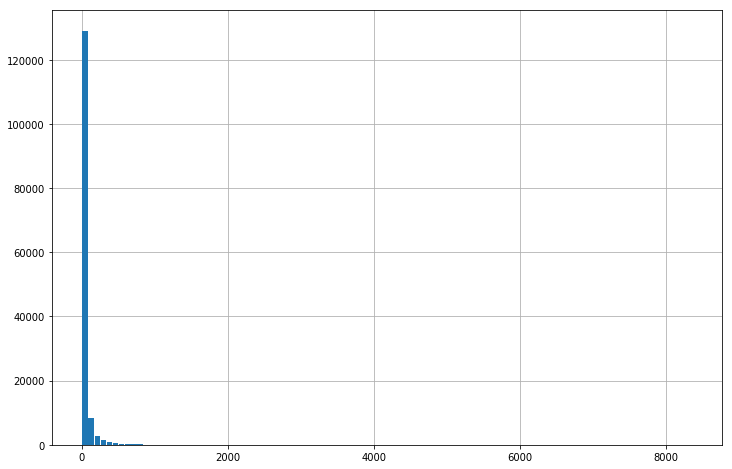

In [28]:
df['review_count'].hist(bins=100, figsize=(12,8), zorder=2, rwidth=0.9)

#### 1.2.4) Feature: 'state'

In [29]:
df['state'].value_counts()

AZ     40489
NV     27609
ON     25445
OH     11160
NC     11156
PA      8682
QC      7871
AB      5692
WI      3880
IL      1343
SC       845
NY        17
CA        10
TX         3
WA         2
BC         1
CT         1
AK         1
XGM        1
UT         1
BAS        1
AL         1
CON        1
GA         1
FL         1
AR         1
XWY        1
VT         1
NM         1
XGL        1
Name: state, dtype: int64

Some states like Texas (TX) and Washington (WA) are only a few times included in the data. For cleaning the data, datasets from these states aren't excluded of further investigations

In [30]:
df = df[(df['state']=='AZ') | 
        (df['state']=='NV') | 
        (df['state']=='ON') | 
        (df['state']=='NC') | 
        (df['state']=='OH') | 
        (df['state']=='PA') | 
        (df['state']=='QC') | 
        (df['state']=='AB') | 
        (df['state']=='WI') | 
        (df['state']=='IL') | 
        (df['state']=='SC')]

In [31]:
# Encode the States
le = LabelEncoder()
le.fit(df['state'].astype(str))
df['state'] = le.transform(df['state'].astype(str)) 
df_encoder = df_encoder.append({'column_name':'state', 'encoder':le}, ignore_index=True)

### 1.2.5) Feature: 'checkin_sum'

In [32]:
df['checkin_sum'].describe()

count    144172.000000
mean        257.970646
std        1548.771811
min           2.000000
25%          10.000000
50%          38.000000
75%         148.000000
max      286122.000000
Name: checkin_sum, dtype: float64

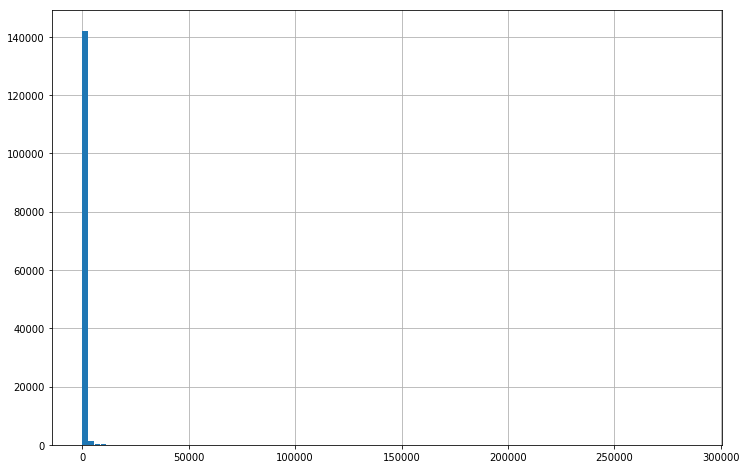

In [33]:
df['checkin_sum'].hist(bins=100, figsize=(12,8), zorder=2, rwidth=0.9)

### 1.2.6) Target: 'stars'

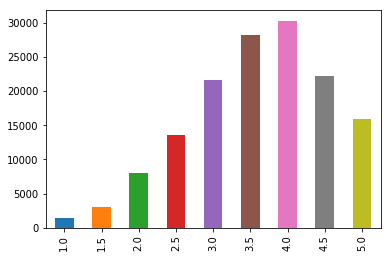

In [34]:
# Distribution of the star ratings
star_count = df['stars'].value_counts()
star_count.reindex([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]).plot.bar()

# 2) Train-, Validation-, Test-Set

In [35]:
df.shape

(144172, 1313)

In [36]:
df = df.reset_index(drop=True)
# Modifiy the target:
target =  2*df['stars']
df = df.drop(columns = ['stars'])

In [37]:
# The dataframe df contains 144172 datasets. 
# Split: Train Set (60%)- Validation Set (20%) - Test Set (20%)
X_train1, X_test, y_train1, y_test = train_test_split(df, target, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

# 4) The Models

## 4.1) Model 1

Build up a model to see how the model preforms and what features are the most important ones.

In [38]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=1, random_state=42)

In [39]:
gbc.fit(X_train1, y_train1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [40]:
print('The accuracy of the first random forest model:')
print('The accuracy of the second random forest model:')
print('Train Set', gbc.score(X_train1, y_train1))
print('Test Set', gbc.score(X_test, y_test))

The accuracy of the first random forest model:
The accuracy of the second random forest model:
Train Set 0.27982347382019646
Test Set 0.2798335356337784


In [41]:
# 20 most important features
print('Most important features:')
feat_importances = pd.Series(gbc.feature_importances_, index=df.columns)
feat_importances.nlargest(20)

Most important features:


review_count                    0.181111
checkin_sum                     0.098889
Fast Food                       0.098889
WheelchairAccessible            0.051111
BusinessParking                 0.048889
Real Estate                     0.035556
Apartments                      0.028889
Burgers                         0.024444
GoodForMeal                     0.023333
state                           0.022222
Chicken Wings                   0.020000
Drugstores                      0.018889
BusinessAcceptsBitcoin          0.017778
NoiseLevel                      0.015556
American (Traditional)          0.015556
RestaurantsPriceRange2          0.014444
Chinese                         0.014444
Hotels                          0.013333
Television Service Providers    0.013333
RestaurantsAttire               0.012222
dtype: float64

In [43]:
# Save the model
filename = 'model_gradient_boostingt.pkl'
pickle.dump(gbc, open(filename, 'wb'))

**Annotation:**

In general the performance of the model is not satisfying. The accuracy is far to low to realistic business insides.

One problem could be, that the classification of 9 classes (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5) is to much. Simultaneously the dataset is not balanced. Not every class is available the same number of times.

# 5) Outlook

This investigation can be extended to increase the performance of rating businesses based on attributes. The following questions show some possibilities for further studies:
* Can correlations between different features can be detected? Can new, relevant features can be generated?
* What is the performance of an other machine learning techniques (e.g. GradientBoostingClassifier, ...) compared to the here used random forest method?
* Does a different labeling (for example frequency based) or an overall feature normalized increase the model?